# PicsArt AI Hackathon Online

## Детектирование фона на изображениях

In [1]:
import sys
sys.executable
from unet import UNet1024

ModuleNotFoundError: No module named 'unet'

In [2]:
%pylab inline

import os
import tqdm

import pandas as pd
#from PIL import Image
from skimage.morphology import remove_small_objects, remove_small_holes

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torchvision.models import vgg13

from utils import rle_encode

Populating the interactive namespace from numpy and matplotlib


In [4]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Normalize,
    Compose,
    PadIfNeeded,
    RandomCrop,
    CenterCrop,
    ToGray
)
import cv2
#from albumentations.torch.functional import img_to_tensor

Загрузим список фотографий из обучающей выборки.

In [5]:
path_images = list(map(
    lambda x: x.split('.')[0],
    filter(lambda x: x.endswith('.png'), os.listdir('data/train_mask_face/'))))

Разделим на обучающую и валидационную выборки. Для ускорения оставим только 24 изображения для валидации.

In [6]:
train_images, val_images = path_images[:-372], path_images[-372:]

Опишем датасет. Предусмотрим загрузку масок из другой директории с теми же названиями файлов.

In [7]:
class FaceDataset(Dataset):
    def __init__(self, images_dir, images_name, target_dir=None,
                 transforms=None):
        
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.images_name = images_name
        self.transforms = transforms
                           
        print('{} images'.format(len(self.images_name)))

    def __len__(self):
        return len(self.images_name)
               
    def __getitem__(self, idx):
        img_filename = os.path.join(
            self.images_dir, self.images_name[idx] + '.png')
        img = cv2.imread(img_filename, cv2.IMREAD_UNCHANGED)
#         print(img.shape)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.target_dir:
            mask_filename = os.path.join(
                self.target_dir, self.images_name[idx] + '.png')
            mask = cv2.imread(mask_filename,0)
            mask = (mask / 255).astype(np.uint8)
        else:
            mask = []
            
        data = {"image": img, "mask": mask}
        augmented = self.transforms(**data)
        img, mask = augmented["image"], augmented["mask"]
        img = img_to_tensor(img)

        #img = self.transforms(img)
        
        #mask = img_to_tensor(mask)
        if len(mask):
#             mask = transforms.ToTensor()(mask)
            mask = torch.from_numpy(np.expand_dims(mask, 0)).float()
        
        return {'img': img, 'mask': mask}

In [8]:
def train_transform(p=1):
        return Compose([
             HorizontalFlip(p=0.5),
             ToGray(p=0.25),
             Normalize(p=1)
        ], p=p)
    
def test_transform(p=1):
        return Compose([
             Normalize(p=1)
        ], p=p)
    

def custom_transform(p=1):
    return Compose([
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])], p=p)
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

В качестве трансформации возьмём только нормализацию с параметрами от ImageNet, так как будем использовать предобученный кодировщик.

In [9]:
train_dataset = FaceDataset(
    images_dir='data/train_mask_face/',
    images_name=train_images,
    target_dir='data/train_mask/',
    transforms=train_transform(p=1))

val_dataset = FaceDataset(
    images_dir='data/train_mask_face/',
    images_name=val_images,
    target_dir='data/train_mask/',
    transforms=train_transform(p=1))

1119 images
372 images


Генераторы для обучения и валидации сети.

In [10]:
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=4)

Для решения задачи сегментации будем использовать UNet. Энкодер сети сделаем из первых блоков предобученного VGG13.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
tt = input_img_resize = (320, 240)
unet = UNet1024((4, *input_img_resize))

if torch.cuda.is_available():
    unet.cuda()
else:
    print("oops no cuda")



Проверим размерность выхода.

In [13]:
for batch in train_data_loader:
    break

out = unet.forward(batch['img'].to(device))
img = out[0].cpu().detach().numpy()
plt.imshow(img[0,:,:])
plt.title('train')
plt.show()
print(batch['img'].shape)
print(out.shape)

print(batch['mask'].shape)
print(unet.parameters())

ValueError: operands could not be broadcast together with shapes (320,240,4) (3,) 

Обучим сеть.

In [13]:
criterion = torch.nn.BCEWithLogitsLoss()
val_criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(unet.parameters())

In [14]:
num_epoch = 1
steps = 0

for epoch in range(num_epoch):
    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()
        output = unet(batch['img'].to(device))
        loss = criterion(output, batch['mask'].to(device))
        loss.backward()
        optimizer.step()
        steps += 1
        
        if steps % 10 == 0:
            val_loss = 0
            for i, batch in enumerate(val_data_loader):
                output = unet(batch['img'].to(device))
                val_loss += float(
                    val_criterion(output, batch['mask'].to(device)).detach())
            val_loss = val_loss / len(val_dataset)
        
            print('steps: {},\ttrain loss: {},\tval loss: {}'.format(
                steps, round(float(loss.detach()), 3), round(val_loss, 3)))

steps: 10,	train loss: 0.587,	val loss: 47174.158
steps: 20,	train loss: 0.613,	val loss: 45815.532
steps: 30,	train loss: 0.597,	val loss: 45219.111
steps: 40,	train loss: 0.53,	val loss: 44754.011
steps: 50,	train loss: 0.546,	val loss: 42798.103
steps: 60,	train loss: 0.481,	val loss: 40326.941
steps: 70,	train loss: 0.52,	val loss: 38669.778
steps: 80,	train loss: 0.506,	val loss: 37712.595
steps: 90,	train loss: 0.404,	val loss: 33820.33
steps: 100,	train loss: 0.572,	val loss: 32621.283
steps: 110,	train loss: 0.49,	val loss: 31462.013
steps: 120,	train loss: 0.356,	val loss: 32477.453
steps: 130,	train loss: 0.359,	val loss: 30943.942
steps: 140,	train loss: 0.283,	val loss: 29777.892
steps: 150,	train loss: 0.274,	val loss: 29148.975
steps: 160,	train loss: 0.533,	val loss: 28662.362
steps: 170,	train loss: 0.304,	val loss: 27764.111
steps: 180,	train loss: 0.326,	val loss: 26757.62
steps: 190,	train loss: 0.435,	val loss: 25737.261
steps: 200,	train loss: 0.338,	val loss: 2742

steps: 3190,	train loss: 0.166,	val loss: 13739.205
steps: 3200,	train loss: 0.184,	val loss: 14215.274
steps: 3210,	train loss: 0.139,	val loss: 13178.801
steps: 3220,	train loss: 0.164,	val loss: 14561.792
steps: 3230,	train loss: 0.107,	val loss: 13232.703
steps: 3240,	train loss: 0.163,	val loss: 14871.885
steps: 3250,	train loss: 0.159,	val loss: 13852.211
steps: 3260,	train loss: 0.214,	val loss: 14130.312
steps: 3270,	train loss: 0.115,	val loss: 13637.459
steps: 3280,	train loss: 0.157,	val loss: 14012.675
steps: 3290,	train loss: 0.184,	val loss: 14473.996
steps: 3300,	train loss: 0.109,	val loss: 14033.34
steps: 3310,	train loss: 0.108,	val loss: 14830.423
steps: 3320,	train loss: 0.126,	val loss: 13619.34
steps: 3330,	train loss: 0.112,	val loss: 13347.486
steps: 3340,	train loss: 0.184,	val loss: 14212.431
steps: 3350,	train loss: 0.152,	val loss: 13652.334
steps: 3360,	train loss: 0.192,	val loss: 13874.028
steps: 3370,	train loss: 0.327,	val loss: 14699.945
steps: 3380,	t

Подготовим итератор по тестовым изображениям.

In [15]:
path_images = list(map(
    lambda x: x.split('.')[0],
    filter(lambda x: x.endswith('.png'), os.listdir('data/test_mask_face/'))))

In [16]:
test_data_loader = DataLoader(
    FaceDataset('data/test_mask_face', path_images, transforms=image_transforms), batch_size=4)

2177 images


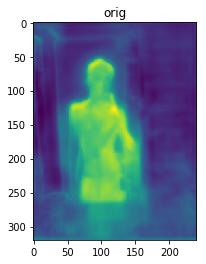

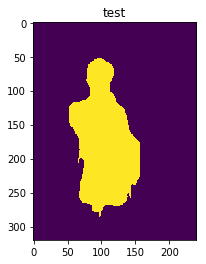

In [17]:
for batch in test_data_loader:
    break

output = unet.forward(batch['img'].to(device))
img = output[3].cpu().detach().numpy()
#img = img[:,:,40:-40]
plt.imshow(img[0,:,:])
plt.title('orig')
plt.show()

threshold = 0.25
post_img = remove_small_holes(remove_small_objects(img > threshold))
# print(post_img.shape)
plt.imshow(post_img[0,:,:])
plt.title('test')
plt.show()

Сделаем предсказания. К выходу сети применим сигмоиду (исходно выходы без нелинейности), сделаем отсечение по порогу и небольшой постобработку по удалению отдельных пикселей маски и закрашиванию дыр. Для кодирования масок в виде массива в формат Run-length encoding используем rle_encode.

In [18]:
threshold = 0.25
predictions = []

for batch in tqdm.tqdm_notebook(test_data_loader):
    output = torch.sigmoid(unet.forward(batch['img'].to(device)))
    for i in range(output.shape[0]):
        img = output[i].cpu().detach().numpy()
        #print(img)
        #break
        post_img = remove_small_holes(remove_small_objects(img > threshold))
        rle = rle_encode(post_img)
        predictions.append(rle)

In [19]:
df = pd.DataFrame.from_dict({'image': path_images, 'rle_mask': predictions})
#df.to_csv('unet1024_face_preprocess_20_epoch.csv', index=False)